# EndoVis 2017 Surgical Instrument Segmentation

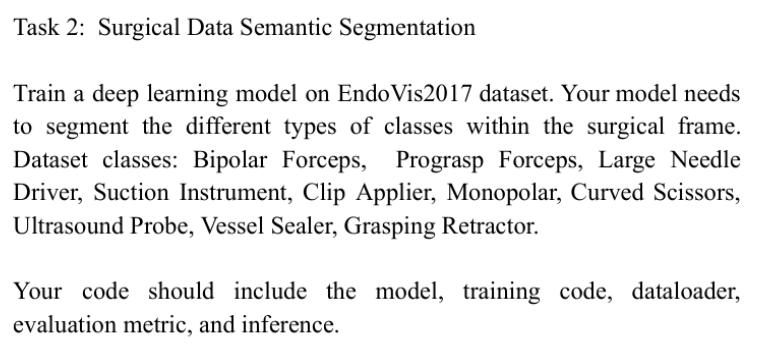


In [1]:

from google.colab import files
import os, zipfile, shutil, cv2, json, tqdm, glob, numpy as np

TINY_ZIP = "EndoVis2017_tiny.zip"     # ~10× smaller
if not os.path.exists(TINY_ZIP):
    print("⇧  Please upload your FULL EndoVis2017 ZIP now …")
    uploaded = files.upload()
    assert len(uploaded)==1, "Upload exactly one ZIP"
    big_zip = next(iter(uploaded))

    print(" Extracting …")
    !unzip -q "$big_zip"

    # Locate dataset root
    DATA_ROOT = None
    for r,d,f in os.walk('.'):
        if 'instrument_type_mapping.json' in f and 'train' in d:
            DATA_ROOT = r; break
    if DATA_ROOT is None:
        raise RuntimeError("instrument_type_mapping.json not found!")

    SHRUNK = f"{DATA_ROOT}_256"
    os.makedirs(SHRUNK, exist_ok=True)
    shutil.copy2(os.path.join(DATA_ROOT, 'instrument_type_mapping.json'), SHRUNK)

    def process_split(split):
        img_src = os.path.join(DATA_ROOT, split, 'image')
        msk_src = os.path.join(DATA_ROOT, split, 'label')
        img_dst = os.path.join(SHRUNK, split, 'image')
        msk_dst = os.path.join(SHRUNK, split, 'label')
        os.makedirs(img_dst, exist_ok=True)
        os.makedirs(msk_dst, exist_ok=True)
        for fname in tqdm.tqdm(sorted(os.listdir(img_src)), desc=f'↳ {split}'):
            im = cv2.imread(os.path.join(img_src, fname))
            im = cv2.resize(im, (256,256), interpolation=cv2.INTER_LINEAR)
            cv2.imwrite(os.path.join(img_dst, fname.replace('.png','.jpg')), im,
                        [int(cv2.IMWRITE_JPEG_QUALITY), 80])

            m  = cv2.imread(os.path.join(msk_src, fname), cv2.IMREAD_GRAYSCALE)
            m  = cv2.resize(m, (256,256), interpolation=cv2.INTER_NEAREST)
            cv2.imwrite(os.path.join(msk_dst, fname), m)

    process_split('train')
    process_split('val1')   # keep only val1

    print("  Zipping shrunk dataset …")
    !zip -qr "$TINY_ZIP" "$SHRUNK"
    print("  Shrunk ZIP ready:", TINY_ZIP)

    shutil.rmtree(DATA_ROOT); shutil.rmtree(SHRUNK); os.remove(big_zip)
else:
    print("🔹 Found tiny ZIP – skipping shrink step")


🔹 Found tiny ZIP – skipping shrink step


In [2]:

import os, json
!unzip -q -o EndoVis2017_tiny.zip
DATA_ROOT = None
for r,d,f in os.walk('.'):
    if 'instrument_type_mapping.json' in f and 'train' in d:
        DATA_ROOT = r; break
assert DATA_ROOT, "DATA_ROOT not found!"
print("DATA_ROOT =", DATA_ROOT)


DATA_ROOT = ./endovis2017_256


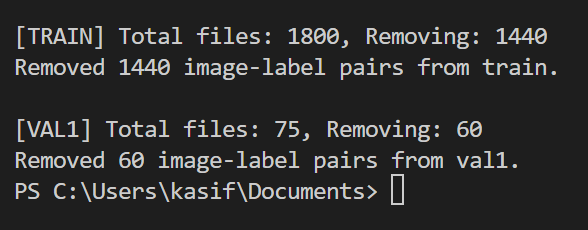

In [3]:

!pip install -q segmentation-models-pytorch==0.3.3 albumentations==1.4.3 --no-cache-dir


# 1. Imports & configuration

In [4]:

import json, os, torch, random, cv2, numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt

SEED           = 42
BATCH_SIZE     = 4
NUM_EPOCHS     = 25
LR             = 1e-4
IMG_SIZE       = 256
TRAIN_SPLIT    = 'train'
VAL_SPLIT      = 'val1'

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

with open(os.path.join(DATA_ROOT, 'instrument_type_mapping.json')) as f:
    id2name = json.load(f)
NUM_CLASSES = 8
print('Classes:', id2name)


Classes: {'Bipolar Forceps': 1, 'Prograsp Forceps': 2, 'Large Needle Driver': 3, 'Vessel Sealer': 4, 'Grasping Retractor': 5, 'Monopolar Curved Scissors': 6, 'Other': 7}


# 2. Dataset class & transforms

Loads EndoVis images and their corresponding masks from folders.

Uses OpenCV to read images and masks.

Applies random flips, rotations, and color jitter for training images.

Validation images are only converted to tensors (no augmentations).

Returns image-mask pairs as PyTorch tensors for model training.

In [5]:

class EndoVisDataset(Dataset):
    def __init__(self, root, split, transforms=None):
        self.image_dir = os.path.join(root, split, 'image')
        self.mask_dir  = os.path.join(root, split, 'label')
        self.fnames = sorted(os.listdir(self.image_dir))
        self.transforms = transforms
    def __len__(self): return len(self.fnames)
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.imread(os.path.join(self.image_dir, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        msk = cv2.imread(os.path.join(self.mask_dir, fname), cv2.IMREAD_GRAYSCALE)
        if self.transforms:
            aug = self.transforms(image=img, mask=msk)
            img, msk = aug['image'], aug['mask']
        return img.float(), msk.long()

train_tfms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),
    ToTensorV2()
])

val_tfms = A.Compose([ToTensorV2()])


# 3. Build DataLoaders

In [6]:

train_set = EndoVisDataset(DATA_ROOT, TRAIN_SPLIT, train_tfms)
val_set   = EndoVisDataset(DATA_ROOT, VAL_SPLIT,   val_tfms)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f'Train images: {len(train_set)} | Val images: {len(val_set)}')


Train images: 360 | Val images: 15


# 4. Model, loss, optimizer


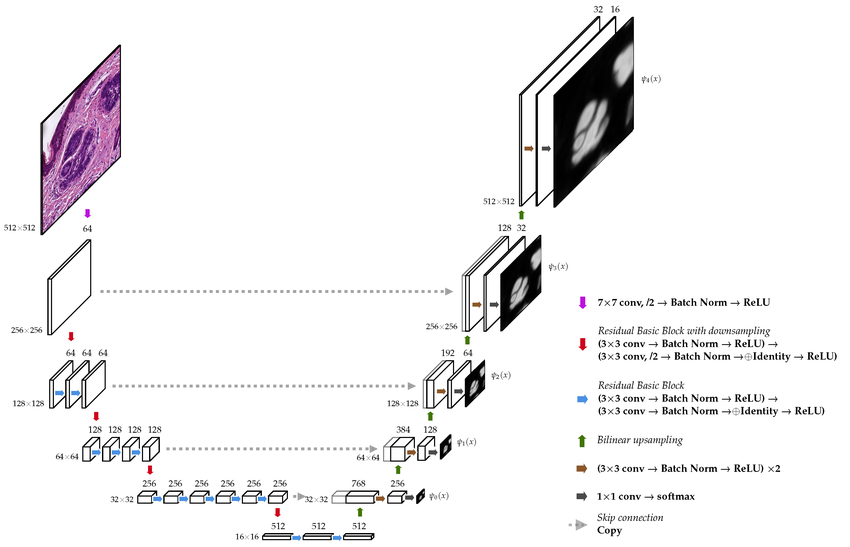

In [7]:

model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=NUM_CLASSES,
).cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

def mIoU(preds, masks, num_classes):
    preds = preds.argmax(1).view(-1)
    masks = masks.view(-1)
    iou=[]
    for cls in range(num_classes):
        inter = torch.sum((preds==cls)&(masks==cls))
        union = torch.sum((preds==cls)|(masks==cls))
        iou.append(torch.tensor(1.0).cuda() if union==0 else inter.float()/union.float())
    return torch.mean(torch.stack(iou))


In [8]:
# debuggerr/ verbose
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# 5. Training loop

In [9]:

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    tot_loss=tot_iou=0; n=len(loader.dataset)
    torch.set_grad_enabled(train)
    for imgs,msk in tqdm(loader, desc='Train' if train else 'Val'):
        #debugger
        print(f"Max Label: {msk.max().item()}, Min Label: {msk.min().item()}")
        assert msk.max() < NUM_CLASSES, f"Invalid label {msk.max()} >= NUM_CLASSES {NUM_CLASSES}"
        assert msk.min() >= 0, f"Invalid negative label {msk.min()}"
        imgs, msk = imgs.cuda(), msk.cuda().long()
        out=model(imgs)
        loss=criterion(out, msk)
        if train:
            optimizer.zero_grad();
            loss.backward();
            optimizer.step()
        tot_loss+=loss.item()*imgs.size(0)
        tot_iou +=mIoU(out, msk, NUM_CLASSES).item()*imgs.size(0)
    return tot_loss/n, tot_iou/n

best=0
for epoch in range(1, NUM_EPOCHS+1):
    tl,ti=run_epoch(train_loader,True)
    vl,vi=run_epoch(val_loader,False)
    print(f'Epoch {epoch:02d}: Train L {tl:.4f} IoU {ti:.3f} | Val L {vl:.4f} IoU {vi:.3f}')
    if vi>best:
        best=vi
        torch.save(model.state_dict(),'best_unet.pth')
        print('Saved new best model')


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Max Label: 6, Min Label: 0


Train:   2%|▏         | 2/90 [00:01<00:44,  1.98it/s]

Max Label: 5, Min Label: 0
Max Label: 6, Min Label: 0


Train:   4%|▍         | 4/90 [00:01<00:20,  4.18it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:   9%|▉         | 8/90 [00:01<00:10,  7.71it/s]

Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  11%|█         | 10/90 [00:01<00:09,  8.65it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  16%|█▌        | 14/90 [00:02<00:07,  9.88it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  18%|█▊        | 16/90 [00:02<00:07,  9.33it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  21%|██        | 19/90 [00:02<00:07,  9.71it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  22%|██▏       | 20/90 [00:02<00:07,  9.42it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  24%|██▍       | 22/90 [00:03<00:07,  9.44it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  28%|██▊       | 25/90 [00:03<00:06,  9.41it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  31%|███       | 28/90 [00:03<00:06,  9.47it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  33%|███▎      | 30/90 [00:03<00:06,  9.91it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  36%|███▌      | 32/90 [00:04<00:05, 10.46it/s]

Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0
Max Label: 6, Min Label: 0


Train:  40%|████      | 36/90 [00:04<00:04, 11.10it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  42%|████▏     | 38/90 [00:04<00:04, 11.61it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0


Train:  47%|████▋     | 42/90 [00:04<00:04, 11.81it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  49%|████▉     | 44/90 [00:05<00:04, 11.48it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  53%|█████▎    | 48/90 [00:05<00:03, 11.04it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  56%|█████▌    | 50/90 [00:05<00:03, 11.10it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  58%|█████▊    | 52/90 [00:05<00:03,  9.88it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  62%|██████▏   | 56/90 [00:06<00:03, 10.80it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  64%|██████▍   | 58/90 [00:06<00:03, 10.55it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  67%|██████▋   | 60/90 [00:06<00:03,  9.95it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  69%|██████▉   | 62/90 [00:07<00:03,  7.96it/s]

Max Label: 6, Min Label: 0
Max Label: 3, Min Label: 0


Train:  71%|███████   | 64/90 [00:07<00:03,  8.03it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  73%|███████▎  | 66/90 [00:07<00:02,  8.02it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  76%|███████▌  | 68/90 [00:07<00:02,  8.36it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  78%|███████▊  | 70/90 [00:08<00:02,  7.84it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  80%|████████  | 72/90 [00:08<00:02,  8.22it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  82%|████████▏ | 74/90 [00:08<00:01,  8.40it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  84%|████████▍ | 76/90 [00:08<00:01,  7.99it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  87%|████████▋ | 78/90 [00:09<00:01,  7.69it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  89%|████████▉ | 80/90 [00:09<00:01,  7.28it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  91%|█████████ | 82/90 [00:09<00:01,  7.75it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  96%|█████████▌| 86/90 [00:09<00:00,  9.88it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  98%|█████████▊| 88/90 [00:10<00:00, 10.91it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 11.84it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00,  8.21it/s]


Epoch 01: Train L 1.6133 IoU 0.099 | Val L 1.1037 IoU 0.131
Saved new best model


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Max Label: 7, Min Label: 0


Train:   1%|          | 1/90 [00:00<00:22,  3.96it/s]

Max Label: 7, Min Label: 0


Train:   2%|▏         | 2/90 [00:00<00:17,  5.17it/s]

Max Label: 7, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:14,  6.15it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:11,  7.23it/s]

Max Label: 7, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:09,  8.78it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  11%|█         | 10/90 [00:01<00:08,  9.64it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  13%|█▎        | 12/90 [00:01<00:07, 10.31it/s]

Max Label: 5, Min Label: 0
Max Label: 6, Min Label: 0


Train:  16%|█▌        | 14/90 [00:01<00:06, 11.04it/s]

Max Label: 7, Min Label: 0


Train:  18%|█▊        | 16/90 [00:01<00:06, 10.85it/s]

Max Label: 5, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  20%|██        | 18/90 [00:01<00:06, 11.15it/s]

Max Label: 5, Min Label: 0
Max Label: 6, Min Label: 0


Train:  22%|██▏       | 20/90 [00:02<00:06, 11.62it/s]

Max Label: 7, Min Label: 0


Train:  24%|██▍       | 22/90 [00:02<00:05, 11.65it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  27%|██▋       | 24/90 [00:02<00:06, 10.84it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  31%|███       | 28/90 [00:02<00:05, 11.02it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  33%|███▎      | 30/90 [00:03<00:06,  9.45it/s]

Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  37%|███▋      | 33/90 [00:03<00:06,  9.04it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:03<00:05, 10.20it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  41%|████      | 37/90 [00:03<00:04, 11.29it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:04<00:03, 12.52it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  48%|████▊     | 43/90 [00:04<00:03, 12.91it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:04<00:03, 13.31it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:04<00:03, 13.43it/s]

Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 13.56it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  61%|██████    | 55/90 [00:05<00:02, 13.62it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:05<00:02, 13.73it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:05<00:02, 13.81it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:01, 13.80it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.73it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:06<00:01, 13.52it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:06<00:01, 13.57it/s]

Max Label: 6, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:06<00:00, 13.75it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 13.77it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:07<00:00, 13.82it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:07<00:00, 13.87it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:07<00:00, 14.10it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 17.75it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 02: Train L 0.8594 IoU 0.201 | Val L 0.6195 IoU 0.198


Saved new best model


Train:   1%|          | 1/90 [00:00<00:16,  5.52it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:09,  9.48it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 10.75it/s]

Max Label: 6, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:07, 11.50it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  10%|█         | 9/90 [00:00<00:06, 12.01it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 11.83it/s]

Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:06, 11.95it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  17%|█▋        | 15/90 [00:01<00:06, 11.87it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:06, 11.90it/s]

Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 12.11it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  23%|██▎       | 21/90 [00:01<00:05, 11.97it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 11.96it/s]

Max Label: 4, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:05, 11.89it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  30%|███       | 27/90 [00:02<00:05, 11.92it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 12.28it/s]

Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 12.53it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  37%|███▋      | 33/90 [00:02<00:04, 12.85it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 13.14it/s]

Max Label: 6, Min Label: 0


Train:  41%|████      | 37/90 [00:03<00:04, 13.22it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  43%|████▎     | 39/90 [00:03<00:03, 13.40it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 13.52it/s]

Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.62it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:03<00:03, 13.64it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 13.70it/s]

Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:02, 13.73it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:04<00:02, 13.70it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 13.64it/s]

Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 13.75it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:04<00:02, 13.76it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 13.85it/s]

Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 13.65it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  70%|███████   | 63/90 [00:04<00:01, 13.68it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:01, 13.76it/s]

Max Label: 7, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.75it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:05<00:01, 13.66it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.37it/s]

Max Label: 6, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.01it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:05<00:01, 12.59it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:06<00:01, 12.67it/s]

Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 12.54it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  90%|█████████ | 81/90 [00:06<00:00, 12.87it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.14it/s]

Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.38it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:06<00:00, 13.58it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 13.82it/s]

Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.77it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 03: Train L 0.5475 IoU 0.262 | Val L 0.4271 IoU 0.202


Saved new best model


Train:   1%|          | 1/90 [00:00<00:15,  5.82it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:08, 10.13it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.70it/s]

Max Label: 7, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 12.55it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  10%|█         | 9/90 [00:00<00:06, 12.96it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:05, 13.21it/s]

Max Label: 6, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:05, 13.38it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0


Train:  17%|█▋        | 15/90 [00:01<00:05, 13.38it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 13.52it/s]

Max Label: 6, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 13.62it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  23%|██▎       | 21/90 [00:01<00:05, 13.62it/s]

Max Label: 4, Min Label: 0
Max Label: 4, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:04, 13.62it/s]

Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:01<00:04, 13.72it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  30%|███       | 27/90 [00:02<00:04, 13.76it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.74it/s]

Max Label: 5, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 13.75it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  37%|███▋      | 33/90 [00:02<00:04, 13.75it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:03, 13.77it/s]

Max Label: 6, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:03, 13.77it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  43%|████▎     | 39/90 [00:02<00:03, 13.74it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 13.74it/s]

Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.79it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:03<00:03, 13.84it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 13.87it/s]

Max Label: 6, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:02, 13.83it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:03<00:02, 13.75it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:03<00:02, 13.69it/s]

Max Label: 3, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 13.73it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:04<00:02, 13.71it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 13.72it/s]

Max Label: 6, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 13.74it/s]

Max Label: 4, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  70%|███████   | 63/90 [00:04<00:01, 13.74it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:04<00:01, 13.72it/s]

Max Label: 6, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:04<00:01, 13.67it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:05<00:01, 13.71it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.37it/s]

Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.26it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:05<00:01, 13.26it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:05<00:01, 12.97it/s]

Max Label: 6, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:05<00:00, 12.68it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  90%|█████████ | 81/90 [00:06<00:00, 12.34it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 12.33it/s]

Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 12.36it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:06<00:00, 12.45it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 12.59it/s]

Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 11.55it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 04: Train L 0.4130 IoU 0.314 | Val L 0.3524 IoU 0.252


Saved new best model


Train:   1%|          | 1/90 [00:00<00:15,  5.79it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 5, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:08, 10.11it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.72it/s]

Max Label: 7, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 12.59it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  10%|█         | 9/90 [00:00<00:06, 13.03it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:05, 13.27it/s]

Max Label: 4, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:05, 13.45it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  17%|█▋        | 15/90 [00:01<00:05, 13.56it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 13.61it/s]

Max Label: 6, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 13.58it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  23%|██▎       | 21/90 [00:01<00:05, 13.53it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:04, 13.57it/s]

Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:01<00:04, 13.64it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  30%|███       | 27/90 [00:02<00:04, 13.65it/s]

Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.68it/s]

Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 13.72it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  37%|███▋      | 33/90 [00:02<00:04, 13.65it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 13.68it/s]

Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:03, 13.55it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  43%|████▎     | 39/90 [00:02<00:03, 13.50it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 13.48it/s]

Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.10it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:03<00:03, 13.27it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 13.45it/s]

Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 13.53it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:03<00:02, 13.49it/s]

Max Label: 6, Min Label: 0
Max Label: 5, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:03<00:02, 13.59it/s]

Max Label: 6, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 13.65it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:04<00:02, 13.70it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 13.73it/s]

Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 13.71it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  70%|███████   | 63/90 [00:04<00:01, 13.57it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:04<00:01, 13.66it/s]

Max Label: 5, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.64it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:05<00:01, 13.70it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.72it/s]

Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.61it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:05<00:01, 13.68it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:05<00:00, 13.74it/s]

Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:05<00:00, 13.67it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  90%|█████████ | 81/90 [00:06<00:00, 13.56it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.60it/s]

Max Label: 4, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.60it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:06<00:00, 13.68it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 13.84it/s]

Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.55it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 05: Train L 0.3456 IoU 0.359 | Val L 0.3746 IoU 0.259


Saved new best model


Train:   1%|          | 1/90 [00:00<00:16,  5.36it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:09,  9.51it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.22it/s]

Max Label: 6, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 12.15it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  10%|█         | 9/90 [00:00<00:06, 12.71it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 13.04it/s]

Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:05, 13.25it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  17%|█▋        | 15/90 [00:01<00:05, 13.38it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 13.48it/s]

Max Label: 6, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 13.52it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  23%|██▎       | 21/90 [00:01<00:05, 13.55it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:04, 13.62it/s]

Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:01<00:04, 13.67it/s]

Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0


Train:  30%|███       | 27/90 [00:02<00:04, 13.70it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.71it/s]

Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 13.76it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  37%|███▋      | 33/90 [00:02<00:04, 13.69it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 13.71it/s]

Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:04, 13.21it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0


Train:  43%|████▎     | 39/90 [00:03<00:03, 12.99it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 12.63it/s]

Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 12.73it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:03<00:03, 12.60it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 12.63it/s]

Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 12.67it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:03<00:03, 12.50it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 12.34it/s]

Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 12.10it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:04<00:02, 12.12it/s]

Max Label: 5, Min Label: 0
Max Label: 4, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 12.01it/s]

Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 11.91it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  70%|███████   | 63/90 [00:04<00:02, 11.60it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:02, 11.93it/s]

Max Label: 6, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 12.39it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:05<00:01, 12.74it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.03it/s]

Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.22it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:05<00:01, 13.36it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:06<00:00, 13.40it/s]

Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 13.42it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 5, Min Label: 0


Train:  90%|█████████ | 81/90 [00:06<00:00, 13.47it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.55it/s]

Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.58it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:06<00:00, 13.70it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 13.87it/s]

Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 18.11it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 06: Train L 0.3081 IoU 0.392 | Val L 0.3424 IoU 0.247


Train:   1%|          | 1/90 [00:00<00:16,  5.48it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.45it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 12.19it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.97it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:05, 13.16it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 13.37it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 13.44it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 13.37it/s]

Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:01<00:04, 13.41it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.52it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 13.65it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 13.71it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:03, 13.60it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 13.56it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.56it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 13.63it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 13.63it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 13.60it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 13.65it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 13.64it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 13.67it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:04<00:01, 13.69it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.67it/s]

Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.72it/s]

Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.66it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:05<00:00, 13.58it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:05<00:00, 13.61it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.52it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.49it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 13.68it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 14.13it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 07: Train L 0.2730 IoU 0.430 | Val L 0.3214 IoU 0.265


Saved new best model


Train:   1%|          | 1/90 [00:00<00:15,  5.64it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:08,  9.83it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.32it/s]

Max Label: 7, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 12.05it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  10%|█         | 9/90 [00:00<00:06, 12.02it/s]

Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.25it/s]

Max Label: 4, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:06, 12.29it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  17%|█▋        | 15/90 [00:01<00:06, 12.05it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:06, 11.91it/s]

Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 12.02it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  23%|██▎       | 21/90 [00:01<00:05, 12.01it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 12.26it/s]

Max Label: 6, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:05, 12.18it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  30%|███       | 27/90 [00:02<00:05, 12.28it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 12.47it/s]

Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 12.45it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  37%|███▋      | 33/90 [00:02<00:04, 12.31it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 12.13it/s]

Max Label: 6, Min Label: 0


Train:  41%|████      | 37/90 [00:03<00:04, 12.38it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  43%|████▎     | 39/90 [00:03<00:04, 12.70it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 12.95it/s]

Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.13it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:03<00:03, 13.17it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 13.33it/s]

Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 13.39it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 3, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:04<00:02, 13.47it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 13.48it/s]

Max Label: 4, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 13.57it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:04<00:02, 13.52it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 13.52it/s]

Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 13.60it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  70%|███████   | 63/90 [00:04<00:01, 13.61it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:01, 13.62it/s]

Max Label: 7, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.51it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:05<00:01, 13.60it/s]

Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.59it/s]

Max Label: 5, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.58it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:05<00:01, 13.51it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:06<00:00, 13.58it/s]

Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 13.61it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  90%|█████████ | 81/90 [00:06<00:00, 13.68it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.66it/s]

Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.60it/s]

Max Label: 4, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:06<00:00, 13.67it/s]

Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 13.87it/s]

Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.77it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 08: Train L 0.2555 IoU 0.430 | Val L 0.3163 IoU 0.361


Saved new best model


Train:   1%|          | 1/90 [00:00<00:16,  5.39it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:09,  9.44it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.17it/s]

Max Label: 7, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 12.10it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  10%|█         | 9/90 [00:00<00:06, 12.66it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 13.01it/s]

Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:05, 13.29it/s]

Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  17%|█▋        | 15/90 [00:01<00:05, 13.39it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 13.46it/s]

Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 13.49it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  23%|██▎       | 21/90 [00:01<00:05, 13.59it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:04, 13.44it/s]

Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:01<00:04, 13.40it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  30%|███       | 27/90 [00:02<00:04, 13.40it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.46it/s]

Max Label: 6, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 13.57it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  37%|███▋      | 33/90 [00:02<00:04, 13.59it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 13.56it/s]

Max Label: 6, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:03, 13.40it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  43%|████▎     | 39/90 [00:02<00:03, 13.49it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 13.55it/s]

Max Label: 4, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.58it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:03<00:03, 13.62it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 13.64it/s]

Max Label: 6, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 13.62it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:03<00:02, 13.59it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 13.64it/s]

Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 13.69it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 3, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:04<00:02, 13.73it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 13.73it/s]

Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 13.60it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  70%|███████   | 63/90 [00:04<00:02, 13.35it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:04<00:01, 13.36it/s]

Max Label: 7, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.41it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:05<00:01, 13.41it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.42it/s]

Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.47it/s]

Max Label: 4, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 6, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:05<00:01, 13.29it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:05<00:01, 12.69it/s]

Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:05<00:00, 12.54it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  90%|█████████ | 81/90 [00:06<00:00, 12.80it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 12.97it/s]

Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 12.58it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:06<00:00, 12.70it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 13.13it/s]

Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 09: Train L 0.2370 IoU 0.439 | Val L 0.3095 IoU 0.300


Train:   1%|          | 1/90 [00:00<00:23,  3.85it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:11,  7.55it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:08, 10.29it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  10%|█         | 9/90 [00:00<00:07, 11.29it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:06, 12.19it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  17%|█▋        | 15/90 [00:01<00:06, 12.48it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 12.05it/s]

Max Label: 3, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  23%|██▎       | 21/90 [00:01<00:05, 12.08it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:05, 11.67it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  30%|███       | 27/90 [00:02<00:05, 11.44it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:05, 11.09it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  37%|███▋      | 33/90 [00:02<00:05, 11.18it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:03<00:04, 11.36it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  43%|████▎     | 39/90 [00:03<00:04, 11.55it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 12.39it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:03<00:03, 12.31it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 4, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:04<00:03, 12.76it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:04<00:03, 12.95it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 13.09it/s]

Max Label: 3, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:04<00:02, 13.09it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:05<00:02, 13.35it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  70%|███████   | 63/90 [00:05<00:02, 13.34it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.46it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:05<00:01, 13.45it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:06<00:01, 13.52it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:06<00:01, 13.51it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 13.54it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  90%|█████████ | 81/90 [00:06<00:00, 13.52it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.45it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:07<00:00, 13.57it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train: 100%|██████████| 90/90 [00:07<00:00, 12.26it/s]


Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 17.26it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 10: Train L 0.2282 IoU 0.466 | Val L 0.3031 IoU 0.233


Train:   1%|          | 1/90 [00:00<00:17,  5.01it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 10.72it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:07, 11.65it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.70it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:05, 12.84it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  17%|█▋        | 15/90 [00:01<00:05, 12.96it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:07,  9.85it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  23%|██▎       | 21/90 [00:01<00:07,  9.72it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:02<00:06, 10.57it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:05, 11.25it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  30%|███       | 27/90 [00:02<00:06, 10.18it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  33%|███▎      | 30/90 [00:02<00:06,  9.16it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  36%|███▌      | 32/90 [00:03<00:06,  8.54it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  40%|████      | 36/90 [00:03<00:05, 10.15it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  42%|████▏     | 38/90 [00:03<00:06,  8.55it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  44%|████▍     | 40/90 [00:04<00:07,  6.74it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  47%|████▋     | 42/90 [00:04<00:08,  5.66it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:04<00:05,  7.73it/s]

Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:05<00:04,  8.90it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:05<00:03, 10.39it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:05<00:03, 10.76it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:05<00:02, 11.71it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:06<00:02, 12.20it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  70%|███████   | 63/90 [00:06<00:02, 12.86it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:06<00:01, 13.04it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 5, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:06<00:01, 13.04it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:06<00:01, 13.22it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:07<00:01, 13.37it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:07<00:00, 13.36it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  90%|█████████ | 81/90 [00:07<00:00, 13.08it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:07<00:00, 13.19it/s]

Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:08<00:00, 13.41it/s]

Max Label: 5, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train: 100%|██████████| 90/90 [00:08<00:00, 10.65it/s]


Max Label: 6, Min Label: 0
Max Label: 5, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.64it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 11: Train L 0.2055 IoU 0.494 | Val L 0.3420 IoU 0.205


Train:   1%|          | 1/90 [00:00<00:17,  4.99it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.06it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 11.98it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.99it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:05, 13.15it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 13.26it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 13.42it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:04, 13.46it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  28%|██▊       | 25/90 [00:01<00:04, 13.51it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.37it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 13.41it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 13.39it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:04, 12.69it/s]

Max Label: 5, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:04, 11.48it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:04, 11.16it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:03<00:04, 10.83it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:04, 10.08it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:04<00:04,  9.56it/s]

Max Label: 6, Min Label: 0
Max Label: 3, Min Label: 0
Max Label: 7, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:03, 10.08it/s]

Max Label: 3, Min Label: 0
Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:03,  9.64it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:05<00:03, 10.33it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:05<00:02, 10.23it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:02,  9.84it/s]

Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0


Train:  73%|███████▎  | 66/90 [00:05<00:02,  8.77it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  76%|███████▌  | 68/90 [00:06<00:02,  9.32it/s]

Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:06<00:02,  9.01it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  82%|████████▏ | 74/90 [00:06<00:01,  9.68it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  84%|████████▍ | 76/90 [00:06<00:01,  9.63it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  87%|████████▋ | 78/90 [00:07<00:01,  8.76it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  89%|████████▉ | 80/90 [00:07<00:01,  8.44it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  91%|█████████ | 82/90 [00:07<00:01,  7.95it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  93%|█████████▎| 84/90 [00:08<00:00,  6.72it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  96%|█████████▌| 86/90 [00:08<00:00,  7.13it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  98%|█████████▊| 88/90 [00:08<00:00,  7.51it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train: 100%|██████████| 90/90 [00:08<00:00,  5.83it/s]

Max Label: 7, Min Label: 0


Val:  25%|██▌       | 1/4 [00:00<00:01,  2.42it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


Epoch 12: Train L 0.1925 IoU 0.509 | Val L 0.3380 IoU 0.230


Train:   1%|          | 1/90 [00:00<00:35,  2.49it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:17,  5.02it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   7%|▋         | 6/90 [00:00<00:10,  8.30it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  10%|█         | 9/90 [00:01<00:09,  8.87it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  13%|█▎        | 12/90 [00:01<00:08,  9.33it/s]

Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:08,  9.33it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  18%|█▊        | 16/90 [00:01<00:07,  9.66it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:02<00:07,  9.45it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  23%|██▎       | 21/90 [00:02<00:07,  9.53it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0


Train:  27%|██▋       | 24/90 [00:02<00:07,  9.28it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  29%|██▉       | 26/90 [00:03<00:07,  9.08it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  31%|███       | 28/90 [00:03<00:06,  9.38it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  36%|███▌      | 32/90 [00:03<00:05, 10.06it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  37%|███▋      | 33/90 [00:03<00:05, 10.02it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:04<00:05,  9.90it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  42%|████▏     | 38/90 [00:04<00:05,  9.24it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  47%|████▋     | 42/90 [00:04<00:04, 11.19it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  49%|████▉     | 44/90 [00:04<00:03, 11.82it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  53%|█████▎    | 48/90 [00:05<00:03, 12.55it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  56%|█████▌    | 50/90 [00:05<00:03, 12.79it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  60%|██████    | 54/90 [00:05<00:02, 13.21it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  62%|██████▏   | 56/90 [00:05<00:02, 13.28it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  67%|██████▋   | 60/90 [00:05<00:02, 13.42it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  69%|██████▉   | 62/90 [00:06<00:02, 13.34it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  73%|███████▎  | 66/90 [00:06<00:01, 13.30it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  76%|███████▌  | 68/90 [00:06<00:01, 13.45it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  80%|████████  | 72/90 [00:06<00:01, 13.36it/s]

Max Label: 4, Min Label: 0
Max Label: 3, Min Label: 0
Max Label: 6, Min Label: 0


Train:  82%|████████▏ | 74/90 [00:06<00:01, 13.48it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  87%|████████▋ | 78/90 [00:07<00:00, 13.45it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  89%|████████▉ | 80/90 [00:07<00:00, 13.47it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  93%|█████████▎| 84/90 [00:07<00:00, 13.54it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  96%|█████████▌| 86/90 [00:07<00:00, 13.42it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train: 100%|██████████| 90/90 [00:08<00:00, 10.97it/s]


Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.95it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 13: Train L 0.1805 IoU 0.529 | Val L 0.3621 IoU 0.174


Train:   1%|          | 1/90 [00:00<00:16,  5.37it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.43it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 12.29it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.71it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:05, 12.94it/s]

Max Label: 3, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 13.08it/s]

Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0
Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 13.08it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 12.47it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:05, 12.55it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 12.83it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 12.80it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 12.23it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:04, 12.19it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 12.29it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 12.32it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 12.13it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 11.63it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:03, 12.18it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 12.61it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 12.91it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 13.16it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:01, 13.43it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.49it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.55it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.59it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:06<00:00, 13.52it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 13.52it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.50it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.38it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 13.66it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 17.42it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 14: Train L 0.1607 IoU 0.561 | Val L 0.3534 IoU 0.222


Train:   1%|          | 1/90 [00:00<00:16,  5.30it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.32it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 11.99it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.84it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:06, 12.76it/s]

Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 4, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 13.07it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 13.24it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 13.09it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:04, 13.02it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.16it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 13.30it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 13.27it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:04, 13.03it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 13.23it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.21it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 12.95it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 13.16it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 13.22it/s]

Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 13.35it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 13.38it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 13.43it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:01, 13.60it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.66it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.55it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.40it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:05<00:00, 13.20it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 13.34it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.24it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.23it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 13.41it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 11.66it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 15: Train L 0.1563 IoU 0.576 | Val L 0.3810 IoU 0.284


Train:   1%|          | 1/90 [00:00<00:25,  3.43it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:12,  7.03it/s]

Max Label: 4, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:08, 10.04it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  10%|█         | 9/90 [00:00<00:07, 10.45it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:07, 10.97it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  17%|█▋        | 15/90 [00:01<00:06, 11.40it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:06, 11.64it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  23%|██▎       | 21/90 [00:01<00:05, 12.04it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:05, 12.65it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  30%|███       | 27/90 [00:02<00:04, 12.82it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 12.93it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  37%|███▋      | 33/90 [00:02<00:04, 12.78it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:03<00:04, 13.00it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  43%|████▎     | 39/90 [00:03<00:03, 13.14it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.35it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:03<00:03, 13.33it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:04<00:03, 13.18it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:04<00:02, 13.18it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 13.21it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:04<00:02, 13.23it/s]

Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 6, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:05<00:02, 13.16it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  70%|███████   | 63/90 [00:05<00:02, 13.17it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.14it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:05<00:01, 13.18it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.15it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:06<00:01, 13.26it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 13.34it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  90%|█████████ | 81/90 [00:06<00:00, 13.24it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.28it/s]

Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:06<00:00, 13.27it/s]

Max Label: 6, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0


Train: 100%|██████████| 90/90 [00:07<00:00, 12.42it/s]


Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.90it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 16: Train L 0.1510 IoU 0.585 | Val L 0.3585 IoU 0.313


Train:   1%|          | 1/90 [00:00<00:16,  5.40it/s]

Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.39it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 12.22it/s]

Max Label: 3, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.76it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:05, 12.85it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 13.03it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 12.75it/s]

Max Label: 6, Min Label: 0
Max Label: 3, Min Label: 0
Max Label: 6, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 13.15it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  28%|██▊       | 25/90 [00:01<00:04, 13.18it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.32it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 13.41it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 13.39it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:03, 13.49it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 13.35it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.27it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 13.23it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 13.21it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 13.28it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 13.34it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 12.92it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 12.68it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:02, 12.22it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 12.20it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 12.03it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 11.80it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:06<00:01, 11.61it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 11.82it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 11.63it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 11.59it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:07<00:00, 12.56it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.62it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 17: Train L 0.1332 IoU 0.615 | Val L 0.3653 IoU 0.312


Train:   1%|          | 1/90 [00:00<00:17,  5.20it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.12it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:07, 11.81it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.72it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:05, 12.93it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 12.98it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 13.12it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 13.28it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:01<00:04, 13.35it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.24it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 13.22it/s]

Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 13.30it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:04, 13.23it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 13.08it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.21it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 13.19it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 13.13it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 13.30it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 13.21it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 13.13it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 13.13it/s]

Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 4, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:01, 13.04it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.06it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.31it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 12.80it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:05<00:00, 13.13it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 13.21it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.32it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.27it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 13.38it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.43it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 18: Train L 0.1221 IoU 0.629 | Val L 0.4346 IoU 0.489


Saved new best model


Train:   1%|          | 1/90 [00:00<00:17,  5.04it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:09,  9.22it/s]

Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.01it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 11.94it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  10%|█         | 9/90 [00:00<00:06, 12.56it/s]

Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 13.00it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:05, 13.08it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  17%|█▋        | 15/90 [00:01<00:05, 12.99it/s]

Max Label: 6, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 12.98it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 13.00it/s]

Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0


Train:  23%|██▎       | 21/90 [00:01<00:05, 13.19it/s]

Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 13.22it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:05, 12.84it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  30%|███       | 27/90 [00:02<00:05, 12.12it/s]

Max Label: 7, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:05, 11.71it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 12.05it/s]

Max Label: 5, Min Label: 0
Max Label: 6, Min Label: 0


Train:  37%|███▋      | 33/90 [00:02<00:04, 12.32it/s]

Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 12.11it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:03<00:04, 12.08it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  43%|████▎     | 39/90 [00:03<00:04, 12.04it/s]

Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:04, 11.88it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:04, 11.71it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:03<00:03, 11.86it/s]

Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 11.78it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:04<00:03, 11.82it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:04<00:03, 11.96it/s]

Max Label: 6, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:03, 11.61it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 11.73it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:04<00:02, 12.01it/s]

Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 12.25it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:05<00:02, 12.47it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  70%|███████   | 63/90 [00:05<00:02, 12.75it/s]

Max Label: 6, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:01, 12.91it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 12.88it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:05<00:01, 13.05it/s]

Max Label: 7, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.05it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.15it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:06<00:01, 13.08it/s]

Max Label: 4, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:06<00:00, 13.08it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 13.18it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  90%|█████████ | 81/90 [00:06<00:00, 13.10it/s]

Max Label: 7, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.24it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.22it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:07<00:00, 13.23it/s]

Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:07<00:00, 13.42it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.01it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 19: Train L 0.1275 IoU 0.612 | Val L 0.3495 IoU 0.281


Train:   1%|          | 1/90 [00:00<00:16,  5.39it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 11.12it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:06, 11.99it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.59it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:06, 12.52it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 12.77it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 12.94it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 13.14it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:04, 13.20it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.08it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 13.12it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 13.14it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:04, 13.17it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 13.24it/s]

Max Label: 6, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.16it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 13.13it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 13.05it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 13.01it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 12.95it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 5, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 13.16it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 13.24it/s]

Max Label: 3, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:01, 13.32it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.05it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.11it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.10it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:05<00:00, 13.16it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 13.27it/s]

Max Label: 6, Min Label: 0
Max Label: 3, Min Label: 0
Max Label: 6, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.27it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.21it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 13.45it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 13.42it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 20: Train L 0.1132 IoU 0.662 | Val L 0.3940 IoU 0.490


Saved new best model


Train:   0%|          | 0/90 [00:00<?, ?it/s]

Max Label: 7, Min Label: 0


Train:   1%|          | 1/90 [00:00<00:21,  4.08it/s]

Max Label: 7, Min Label: 0


Train:   2%|▏         | 2/90 [00:00<00:15,  5.52it/s]

Max Label: 7, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:15,  5.44it/s]

Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:16,  5.08it/s]

Max Label: 3, Min Label: 0


Train:   7%|▋         | 6/90 [00:01<00:16,  5.00it/s]

Max Label: 6, Min Label: 0


Train:   8%|▊         | 7/90 [00:01<00:16,  5.12it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  10%|█         | 9/90 [00:01<00:11,  7.09it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:01<00:09,  8.69it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:09,  8.49it/s]

Max Label: 6, Min Label: 0


Train:  17%|█▋        | 15/90 [00:02<00:10,  6.88it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  19%|█▉        | 17/90 [00:02<00:09,  7.72it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0


Train:  23%|██▎       | 21/90 [00:02<00:06, 10.15it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  26%|██▌       | 23/90 [00:02<00:06, 10.91it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:03<00:06,  9.71it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  30%|███       | 27/90 [00:03<00:06,  9.19it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:03<00:05, 10.67it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  37%|███▋      | 33/90 [00:03<00:05, 11.13it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:04<00:04, 12.14it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  43%|████▎     | 39/90 [00:04<00:04, 12.45it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:04<00:03, 12.93it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:04<00:03, 13.07it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:05<00:03, 12.98it/s]

Max Label: 3, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:05<00:03, 12.90it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  61%|██████    | 55/90 [00:05<00:02, 13.04it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:05<00:02, 13.05it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:06<00:02, 13.09it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  70%|███████   | 63/90 [00:06<00:02, 13.22it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:06<00:01, 13.04it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:06<00:01, 13.17it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:07<00:01, 13.06it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:07<00:01, 13.18it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:07<00:00, 12.98it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  90%|█████████ | 81/90 [00:07<00:00, 13.03it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:07<00:00, 13.01it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:08<00:00, 12.92it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train: 100%|██████████| 90/90 [00:08<00:00, 10.75it/s]


Max Label: 5, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.63it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 21: Train L 0.1252 IoU 0.631 | Val L 0.4051 IoU 0.360


Train:   1%|          | 1/90 [00:00<00:17,  5.17it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 10.83it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:07, 11.66it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.41it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:06, 12.64it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 12.90it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 12.74it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 12.91it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:05, 12.95it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.05it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 13.06it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 13.10it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:04, 13.11it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 13.11it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 13.12it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 12.78it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 12.07it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:03, 11.81it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 11.73it/s]

Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 11.48it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 11.65it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 4, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:02, 11.78it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 11.85it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 11.68it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 11.64it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:06<00:01, 12.49it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 12.69it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.07it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.18it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:07<00:00, 13.45it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 17.16it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 22: Train L 0.1205 IoU 0.641 | Val L 0.4040 IoU 0.428


Train:   1%|          | 1/90 [00:00<00:16,  5.29it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 10.65it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:07, 11.41it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.40it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:06, 12.63it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:05, 12.99it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:05, 13.17it/s]

Max Label: 6, Min Label: 0
Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 13.18it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:04, 13.14it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:04, 13.07it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:04, 12.97it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  39%|███▉      | 35/90 [00:02<00:04, 12.93it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:02<00:04, 12.67it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:03, 12.92it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 12.85it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:03<00:03, 12.99it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:03<00:03, 13.00it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 12.75it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 12.91it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 12.91it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:04<00:02, 12.95it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:01, 13.06it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 13.14it/s]

Max Label: 4, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.10it/s]

Max Label: 3, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:05<00:01, 13.16it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:06<00:00, 13.31it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 13.29it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.24it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.14it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:06<00:00, 13.40it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.82it/s]


Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 23: Train L 0.1188 IoU 0.680 | Val L 0.3854 IoU 0.414


Train:   1%|          | 1/90 [00:00<00:17,  5.10it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 10.79it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:07, 11.81it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  12%|█▏        | 11/90 [00:00<00:06, 12.63it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:06, 12.75it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:06, 11.94it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 5, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:06, 11.78it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  26%|██▌       | 23/90 [00:01<00:05, 11.53it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:05, 11.61it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  32%|███▏      | 29/90 [00:02<00:05, 11.71it/s]

Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:02<00:05, 11.63it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  39%|███▉      | 35/90 [00:03<00:04, 11.26it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  41%|████      | 37/90 [00:03<00:04, 11.09it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  46%|████▌     | 41/90 [00:03<00:04, 11.17it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:03<00:03, 11.79it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:04<00:03, 12.45it/s]

Max Label: 6, Min Label: 0
Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:04<00:03, 12.58it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:04<00:02, 12.52it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  61%|██████    | 55/90 [00:04<00:02, 12.84it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:04<00:02, 13.10it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:05<00:02, 13.15it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:05<00:01, 13.14it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:05<00:01, 12.89it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:05<00:01, 13.01it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  81%|████████  | 73/90 [00:06<00:01, 13.16it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:06<00:00, 13.17it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:06<00:00, 12.98it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:06<00:00, 13.11it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 5, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:06<00:00, 13.08it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:07<00:00, 13.44it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.75it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 24: Train L 0.1119 IoU 0.660 | Val L 0.4226 IoU 0.559


Saved new best model


Train:   1%|          | 1/90 [00:00<00:16,  5.45it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:   3%|▎         | 3/90 [00:00<00:09,  9.34it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:   6%|▌         | 5/90 [00:00<00:07, 10.94it/s]

Max Label: 4, Min Label: 0


Train:   8%|▊         | 7/90 [00:00<00:07, 11.82it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  10%|█         | 9/90 [00:00<00:07, 10.95it/s]

Max Label: 6, Min Label: 0


Train:  12%|█▏        | 11/90 [00:01<00:07, 10.59it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  14%|█▍        | 13/90 [00:01<00:07, 10.87it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  17%|█▋        | 15/90 [00:01<00:07, 10.66it/s]

Max Label: 7, Min Label: 0


Train:  19%|█▉        | 17/90 [00:01<00:06, 10.58it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  21%|██        | 19/90 [00:01<00:06, 10.34it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  24%|██▍       | 22/90 [00:02<00:07,  9.56it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  27%|██▋       | 24/90 [00:02<00:07,  9.06it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  28%|██▊       | 25/90 [00:02<00:07,  8.83it/s]

Max Label: 7, Min Label: 0


Train:  29%|██▉       | 26/90 [00:02<00:07,  8.76it/s]

Max Label: 6, Min Label: 0


Train:  30%|███       | 27/90 [00:02<00:07,  8.93it/s]

Max Label: 7, Min Label: 0


Train:  31%|███       | 28/90 [00:02<00:06,  9.00it/s]

Max Label: 7, Min Label: 0


Train:  32%|███▏      | 29/90 [00:03<00:07,  8.22it/s]

Max Label: 3, Min Label: 0


Train:  33%|███▎      | 30/90 [00:03<00:07,  8.25it/s]

Max Label: 7, Min Label: 0


Train:  34%|███▍      | 31/90 [00:03<00:07,  8.14it/s]

Max Label: 7, Min Label: 0


Train:  36%|███▌      | 32/90 [00:03<00:07,  8.19it/s]

Max Label: 4, Min Label: 0


Train:  37%|███▋      | 33/90 [00:03<00:06,  8.34it/s]

Max Label: 6, Min Label: 0


Train:  39%|███▉      | 35/90 [00:03<00:06,  8.71it/s]

Max Label: 5, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  41%|████      | 37/90 [00:03<00:05,  9.83it/s]

Max Label: 6, Min Label: 0


Train:  43%|████▎     | 39/90 [00:04<00:04, 10.58it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  46%|████▌     | 41/90 [00:04<00:04, 11.25it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  48%|████▊     | 43/90 [00:04<00:03, 11.89it/s]

Max Label: 7, Min Label: 0


Train:  50%|█████     | 45/90 [00:04<00:03, 12.37it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  52%|█████▏    | 47/90 [00:04<00:03, 12.68it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0


Train:  54%|█████▍    | 49/90 [00:04<00:03, 12.73it/s]

Max Label: 7, Min Label: 0


Train:  57%|█████▋    | 51/90 [00:04<00:03, 12.97it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0


Train:  59%|█████▉    | 53/90 [00:05<00:02, 12.75it/s]

Max Label: 4, Min Label: 0
Max Label: 6, Min Label: 0


Train:  61%|██████    | 55/90 [00:05<00:02, 12.76it/s]

Max Label: 3, Min Label: 0


Train:  63%|██████▎   | 57/90 [00:05<00:02, 12.72it/s]

Max Label: 6, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  66%|██████▌   | 59/90 [00:05<00:02, 12.88it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  68%|██████▊   | 61/90 [00:05<00:02, 12.60it/s]

Max Label: 7, Min Label: 0


Train:  70%|███████   | 63/90 [00:05<00:02, 12.31it/s]

Max Label: 3, Min Label: 0
Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0


Train:  72%|███████▏  | 65/90 [00:06<00:02, 12.16it/s]

Max Label: 7, Min Label: 0
Max Label: 4, Min Label: 0


Train:  74%|███████▍  | 67/90 [00:06<00:01, 12.02it/s]

Max Label: 6, Min Label: 0


Train:  77%|███████▋  | 69/90 [00:06<00:01, 12.03it/s]

Max Label: 6, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  79%|███████▉  | 71/90 [00:06<00:01, 11.95it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  81%|████████  | 73/90 [00:06<00:01, 11.87it/s]

Max Label: 7, Min Label: 0


Train:  83%|████████▎ | 75/90 [00:06<00:01, 11.81it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  86%|████████▌ | 77/90 [00:07<00:01, 11.72it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0


Train:  88%|████████▊ | 79/90 [00:07<00:00, 11.76it/s]

Max Label: 7, Min Label: 0


Train:  90%|█████████ | 81/90 [00:07<00:00, 12.03it/s]

Max Label: 4, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 3, Min Label: 0


Train:  92%|█████████▏| 83/90 [00:07<00:00, 12.16it/s]

Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  94%|█████████▍| 85/90 [00:07<00:00, 11.96it/s]

Max Label: 7, Min Label: 0


Train:  97%|█████████▋| 87/90 [00:07<00:00, 12.00it/s]

Max Label: 7, Min Label: 0
Max Label: 7, Min Label: 0
Max Label: 6, Min Label: 0


Train:  99%|█████████▉| 89/90 [00:08<00:00, 12.25it/s]

Max Label: 7, Min Label: 0


Val: 100%|██████████| 4/4 [00:00<00:00, 16.77it/s]

Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Max Label: 2, Min Label: 0
Epoch 25: Train L 0.1027 IoU 0.694 | Val L 0.4121 IoU 0.532


# 6. Inference visualization

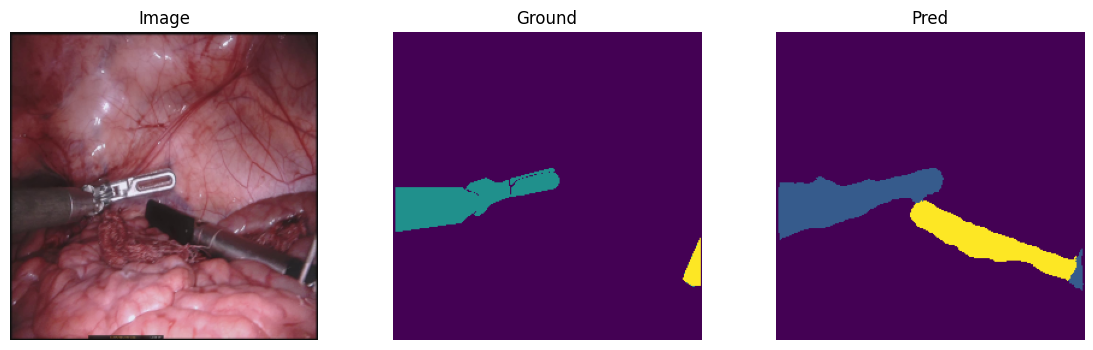

In [19]:

def show(idx=0):
    model.eval()
    img,gt = val_set[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).cuda()).argmax(1).squeeze().cpu().numpy()
    fig,ax=plt.subplots(1,3, figsize=(14,4))
    ax[0].imshow(img.permute(1,2,0).byte()); ax[0].set_title('Image'); ax[0].axis('off')
    ax[1].imshow(gt); ax[1].set_title('Ground'); ax[1].axis('off')
    ax[2].imshow(pred); ax[2].set_title('Pred'); ax[2].axis('off')
show(0)

# Images below
# Prograsp Forceps
# Bipolar Forceps
